In [104]:
import torch
from PIL import Image
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import glob
import os

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = SamModel.from_pretrained("facebook/sam-vit-base")
model = model.to(torch.float32)
model = model.to(device)

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")



cpu


In [ ]:
png_folder = "phys_imgs/png"
png_files = sorted(glob.glob(os.path.join(png_folder, "*.png")))

all_masks = []
all_scores = []

png_folder = "phys_imgs/png"
png_files = sorted(glob.glob(os.path.join(png_folder, "*.png")))

# convert all images to tensors
to_tensor = transforms.ToTensor()
images = [to_tensor(Image.open(f)) for f in png_files]  # each shape [3,H,W]

# stack into batch
batch_images = torch.stack(images).to(device, dtype=torch.float32)  # [B,3,H,W]

# center points for all images
H, W = images[0].shape[1:]  # assumes all images same size
batch_points = torch.tensor([[[W//2, H//2]] for _ in images], dtype=torch.float32).to("cpu")

# prepare processor inputs
inputs = processor(batch_images, input_points=batch_points, return_tensors="pt")
inputs = {k: v.to(device, dtype=torch.float32) for k,v in inputs.items()}

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

# outputs.pred_masks now has batch dimension
print(outputs.pred_masks.shape)  # [batch_size, num_points, H, W] or similar

In [92]:
# force int64 sizes
original = inputs["original_sizes"].to(torch.long).cpu()
reshaped = inputs["reshaped_input_sizes"].to(torch.long).cpu()

pred_masks = outputs.pred_masks.detach().cpu()

masks = processor.image_processor.post_process_masks(
    pred_masks,
    original,
    reshaped
)
mask_tensor = masks[0][0]# original masks has shape (batch_size, number_of_masks, H, W)

In [93]:
def plot_only_mask(single_mask):
    plt.figure(figsize=(12, 8))
    plt.imshow(single_mask.cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

def plot_overlay_mask(single_mask):
    img_np = np.array(raw_img)  # shape [H, W, 3]

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.imshow(single_mask.cpu(), cmap="Reds", alpha=0.5)
    plt.axis("off")
    plt.show()

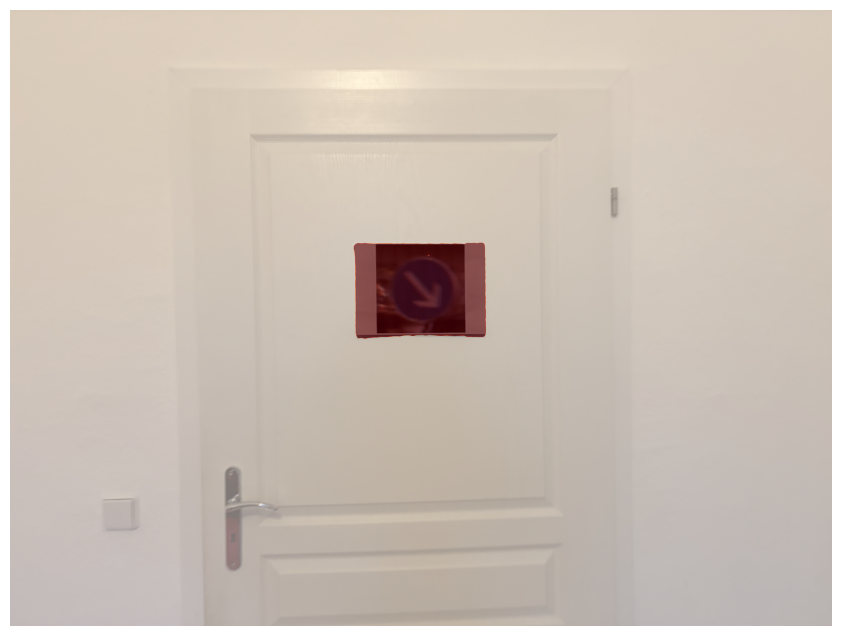

In [94]:
single_mask = mask_tensor[2]  # shape [4284, 5712]

#plot_only_mask(single_mask)
plot_overlay_mask(single_mask)


